# Poisson Maximun-Likelihood estimation
## Description 
- Maximun likehood estimation seeks to estimate parameters maximizing specific likelihood.

## SIR Model
- $$\frac{dS}{dt}=-\beta\frac{SI}{N}$$
  $$\frac{dI}{dt}=\beta\frac{SI}{N}-\gamma I$$
  $$\frac{dR}{dt}=\gamma I$$

In [ ]:
def sirODE(x,t,params):
    #function dxdt = sirODE(t,x,params)
    #x[0] = Susceptibles (S)
    #x[1] = Infecteds    (I)
    #x[2] = Recovered    (R)

    beta = params[0]
    gamma = params[1]

    dSdt = - beta*x[0]*x[1] -;
    dIdt = beta*x[0]*x[1] - gamma*x[1]
    dRdt = gamma*x[1]

    return [dSdt, dIdt, dRdt]

In [1]:

def initial_conditions(data,params):
    #initial_conditions: a function that takes in the current parameter values and
    #returns the initial conditions, i.e. I(0) = data(1)/k, S(0) = 1- I(0),
    #R(0) = 0. Assume the parameter order is: beta, gamma, k.
    Io = data[0]
    k = params[2]
    return [1-Io/k, Io/k, 0]

def measured_cases(x,params):
    #measured_cases: a function that takes in the current model output and parameter
    #values, and returns the measured cases, y = I*k. Note that k =
    #params(3), and I = x(:,2).
    yfcn = x[:,1]*params[2]
    return yfcn

In [2]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
times = np.arange(0,100,7)
# Artificial Data
data = [97,271,860,1995,4419,6549,6321,4763,2571,1385,615,302,159,72,34]; 

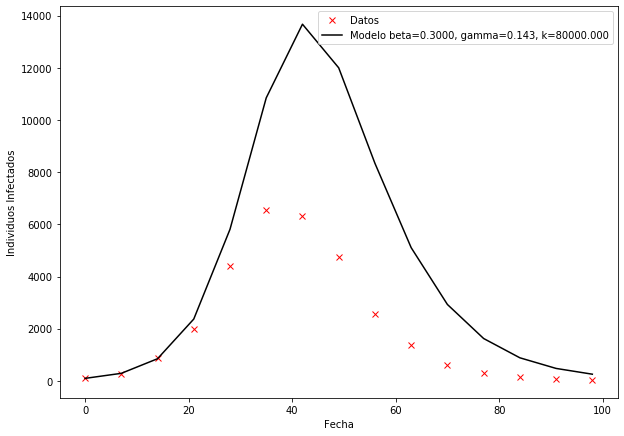

In [3]:
params      = [0.3, 1/7, 80000]; #beta, gamma, k
param_names = {'\beta','\gamma','k'};

x = odeint(sirODE, initial_conditions(data,params), times ,args=(params,))
meas_cases = measured_cases(x,params)
fig = plt.figure(figsize=(10,7.2))


plt.plot(times,data,'rx')
plt.plot(times,meas_cases,'k-')

plt.xlabel('Fecha')
plt.ylabel('Individuos Infectados')
plt.legend(['Datos','Modelo beta={:.4f}, gamma={:.3f}, k={:.3f}'.format(params[0],params[1],params[2])])


In [4]:
def NLL_sirCost(params,tspan,data):

    params = np.abs(params)

    y_out = odeint(sirODE, initial_conditions(data,params), tspan ,args = (params,))


    y = measured_cases(y_out,params)
    NLL = np.sum(y*np.ones((len(y))))-np.sum(data*np.log(y)) #Poisson ML

    #NLL = np.sum((data-y)**2) # Minimos cuadrados

    return NLL


from scipy.optimize import fmin

parameters_ests = fmin( NLL_sirCost, params, args=(times,data))
parameters_ests = np.abs(parameters_ests);
parameters_ests

Optimization terminated successfully.
         Current function value: -219911.211253
         Iterations: 147
         Function evaluations: 288


array([3.99860076e-01, 2.46769982e-01, 8.02565465e+04])

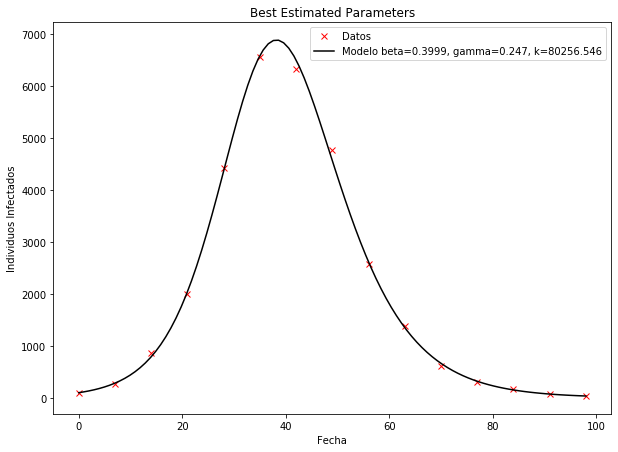

In [5]:
t_sim = np.linspace(times[0],times[-1],100)
x = odeint(sirODE, initial_conditions(data,parameters_ests), t_sim ,args=(parameters_ests,))

meas_cases = measured_cases(x,parameters_ests)

fig = plt.figure(figsize=(10,7.2))


plt.plot(times,data,'rx')
plt.plot(t_sim,meas_cases,'k-')

plt.xlabel('Fecha')
plt.ylabel('Individuos Infectados')
plt.legend(['Datos','Modelo beta={:.4f}, gamma={:.3f}, k={:.3f}'.format(parameters_ests[0],parameters_ests[1],parameters_ests[2])])

plt.title('Best Estimated Parameters')
fig.savefig('casos_02.png', dpi = 400)

# Genetic Algorithm (GA)
## Description 
-  A genetic algorithm is an optimization method that manipulates a string of numbers in a manner similar to how chromosomes are changed in biological evolution.
- An initial population made up of strings of numbers is chosen at random or is specified by the user.
- Each string of numbers is called a "chromosome" or an "individual," and each number slot is called a "gene."
- A set of chromosomes forms a population.  Each chromosome represents a given number of traits which are the actual parameters that are being varied to optimize the "fitness function". 
- The fitness function is a performance index that we seek to *maximize* (What else we want to maximize? YES-> Likelihoods).  

## How de GA works | Pipeline:
- Beginning with the initial population, "selection" is used to choose which chromosomes should survive to form a "mating pool".
- Chromosomes are chosen based on how fit they are (as computed by the fitness function) relative to the other members of the population.
- More fit individuals end up with more copies of themselves in the mating pool so that they will more significantly effect the formation of the next generation.
### What happens with the matting pool?
    ### Crossover 
    -  "Crossover" (which represents mating, the exchange of genetic material) occurs between parents. 
    - To perform crossover, a random spot is picked in the chromosome, and the genes after this spot are switched with the corresponding genes of the other parent.
    
    ### Mutation
    - This is where some genes are randomly changed to other values.
    
### How to finish the procedure?

A termination criterion is used to specify when the GA should 
   - Maximum number of generations
   - Fitness stops increasing

## Definitions of the GA

- A _GENE_ is a digit position that can take on certain values Ex: In a base-10 algorithm a gene can hold any number between 0 and 9.


- A _CHROMOSOME_ is a string of genes. Ex: In base-10 1234567890 could be a chromosome of length 10.


- A _TRAIT_ is a decimal number which is decoded from a chromosome.  Normally, a chromosome is a concatenation of several TRAITS.


- An _INDIVIDUAL_ is the object that the GA is attempting to optimize. An individual is described by its chromosome. The individual's traits determine its fitness.


- A _POPULATION_ is a set of individuals (set of chromosomes).


- _FITNESS FUNCTION_ is the objective function to be optimized which provides the mechanism for evaluating each string (we maximize the fitness function).


- SELECTION: a fitter string receives a higher number of offspring and thus has a higher chance of surviving in the subsequent generation.


- CROSSOVER is an operation which swaps genes between two chromosome.


- MUTATION is flipping a digit in the chromosome after crossover.


## Hyper-parameters for the code
1. NUM_TRAITS (This should be the same as the number of parameters): 
        The number of traits represented by each chromosome (e.g. if we were trying to optimize the above function we could have NUM_TRAITS=2). 
        Example: Chromosome: 123456789012. Possible two traits: 123456, 789012.


2. HIGHTRAIT, LOWTRAIT:  
        Arrays with NUM_TRAITS elements with each element specifying the upper (lower) limit on each trait (often known a priori for an optimization problem). 
        For example, we may only want to find the optimum values of a function over a certain region.  For instance, we could choose HIGHTRAIT=[30 30] and LOWTRAIT=[0 0]. for the above optimization problem.


3. SIG_FIGS: 
        An array with NUM_TRAITS elements with each element specifying the number of significant figures in each trait (there must be at least one significant figure). Example: SIG_FIGS=[6 6] with above possible traits. 


4. DECIMAL: 
        An array with NUM_TRAITS elements with each element specifying the number of digits to the left of the decimal point for each trait.  Choose DECIMAL to be the largest number integer part in HIGHTRAIT or LOWTRAIT to avoid saturation.
        (Example: HIGHTRAIT=[12.9 9.9], LOWTRAIT=[5.5 -5.5], DECIMAL=[2 1] so for our optimization problem let DECIMAL=[2 2]). 
   
5. MUTAT_PROB:  
        The probability that a mutation will occur in any given gene (i.e., that a gene will be switched to another element of the alphabet that is being used).  Note that for base 10 we randomly choose a number between 0-9, with the exception of the number that was being mutated.

6.  CROSS_PROB:
        The probability that a crossover will occur between two parents (standard swapping of genes is used).

7.  SELF_ENTERED: 
        If this flag is set to 1, an initial population can be entered by the user.  If it is 0, a random initial population is created.  We enter the initial population in a special convenient way for the user.
                    

8. POP_SIZE: 
        The number of individuals in a population (fixed). This should be an even number - since pairs mate.
                 

9. ELITISM:
        If this flag is set to one, the most fit individual in each generation will be carried over to the next generation without being modified in any way by the genetic operators.

10. DELTA, EPSILON: 
        These are for the termination criterion. The program is terminated if the fitness changes less than EPSILON over DELTA generations.
                

11. MAX_GENERATION: 
        The number of generations that the program will produce before stopping.  This indicates the length of the program will run. If it takes too long  to run, this number can be lowered.


# Implementation

## Parameters:
- Notice you should enter here your own parameters for the epidemiological model

In [29]:
import numpy as np 

NUM_TRAITS=2;          # Number of traits in each individual
HIGHTRAIT=[2, 2];   # Upper limit of a trait
LOWTRAIT=[-5, -2]; 	 # Lower limit of a trait
SIG_FIGS=[6, 6];       # Number of genes in each trait
DECIMAL=[1, 1];         # Order of magnitude the trait
MUTAT_PROB=0.02;       # Probability of mutation (typically <.1)
CROSS_PROB=0.5;        # Probability of crossover (typically near 1)
SELF_ENTERED=0;        # "0": a random initial population.
# "1": a specified initial population
# If you choose "1", enter it in the program.
POP_SIZE=20;           # Number of individuals in the population
ELITISM=1;             # Elitism ON/OFF, 1/0
DELTA=100;             # Number of generations to be counted
# for the termination criteria.
EPSILON = 0.01;  	     # Range that the fitness must change
# in the termination criteria.
MAX_GENERATION=1000;   # Number of times the loop will run before

### Initialize the population
Here we want to make the initial population of size = POP_SIZE.
- Each column represents a chromosome and each element in that column representing a gene.
- There will be POP_SIZE chromosomes with each of them having CHROM_LENGTH genes.

In [30]:
popcount = 0 # Initialize the generation count.

if SELF_ENTERED == 0:
    #  Make a random initial population for base-10 operation by specifying the matrix of initial traits
    
    # Matrix to store traits.
    trait  = np.zeros((NUM_TRAITS, POP_SIZE, MAX_GENERATION))
    
    for pop_member in range(POP_SIZE):
        for current_trait in range(NUM_TRAITS):
            rand_num = np.random.rand()
            trait[current_trait,pop_member,popcount] = (rand_num-1/2)*(HIGHTRAIT[current_trait]-LOWTRAIT[current_trait])+(1/2)*(HIGHTRAIT[current_trait]-LOWTRAIT[current_trait])

else: #SELF_ENTERED != 0
    
    for pop_member in range(POP_SIZE):
        for current_trait in range(NUM_TRAITS):

            # To start with a guess where all the population members are zero
            trait[current_trait,pop_member,popcount] = 0


In [31]:
# Length of the chromosome is the number of sig. figs. plus the number of sign positions
CHROM_LENGTH = np.sum(SIG_FIGS)+NUM_TRAITS; 

TRAIT_START = np.zeros((NUM_TRAITS+1))
TRAIT_START[0] = 1 #Initialize: the first trait

# starts at the first digit (this is the sign digit)
for current_trait in range(NUM_TRAITS):
    # Determine the start point of the other traits - it is the start of the last trait plus the no. of sig. figs. plus one for sign
    
    TRAIT_START[current_trait+1] = TRAIT_START[current_trait] + SIG_FIGS[current_trait]+1;
    # Yes, we compute the TRAIT_START for one extra trait - this is used for convenience in the code below.

TRAIT_START

array([ 1.,  8., 15.])

## Fitness:
- Now we calculate the fitness.
- Then create the children and repeat until termination criteria is satisfied.


In [32]:
# First, fix bad traits 
#The ones that are out of the range specified by HIGHTRAIT and LOWTRAIT) by saturation at the extremes.

def fix_trait(trait,HIGHTRAIT,LOWTRAIT,current_trait,pop_member,popcount):

    if trait[current_trait,pop_member,popcount] > HIGHTRAIT[current_trait]:

        # The trait has went higher than the upper
        # bound so let the trait equal to the
        # HIGHTRAIT bound.
        trait[current_trait,pop_member,popcount] = HIGHTRAIT[current_trait]

        # Now consider the other case:

    elif trait[current_trait,pop_member,popcount] < LOWTRAIT[current_trait]:

        # The trait has went lower than the lower
        # bound so let the trait equal to the
        # LOWTRAIT bound
        trait[current_trait,pop_member,popcount] = LOWTRAIT[current_trait]
    return trait

In [33]:
pop = np.zeros( (int(TRAIT_START[-1]),POP_SIZE))
pop.shape

bestfitness    = [] #list to save best fitness
worstfitness   = [] #list to save worst fitness
avefitness     = []
bestindividual = []

while popcount <= MAX_GENERATION:
    #print('Running for generation {}\n'.format(popcount))
    temp_trait = np.zeros((NUM_TRAITS,POP_SIZE))

    # ITERATE TROUGHT CHROMOSOMES
    for pop_member in range(POP_SIZE):
        
        # ITERATE TROUGHT TRAITS
        for current_trait in range(NUM_TRAITS):
                
            #FIX TRAITS SO THEY ARE INSIDE THE SPECIFIED RANGE
            trait = fix_trait(trait,HIGHTRAIT,LOWTRAIT,current_trait,pop_member,popcount)
            
            # Now that we have reset the traits to be in range, we must
            # convert them to the chromosome form for use with the genetic operators.
            # First, we transfer the sign of the trait into the chromosome
            
            if trait[current_trait,pop_member,popcount] < 0:
                pop[ int(TRAIT_START[current_trait]), pop_member] = 0;
            else:
                pop[ int(TRAIT_START[current_trait]), pop_member] = 9;
            
            # Next, strip off the sign and store the resulting value in a
            # temporary variable that is used in the construction of pop
            temp_trait[current_trait,pop_member] = np.abs( trait[current_trait, pop_member, popcount] )
                
            # temp_trait is trait without the sign of trait

            # Next, we store the numbers of the trait in the chromosome:
            # First, set up a temporary trait with at most
            # one nonzero digit to the left of the decimal point.
            # This is used to strip off the numbers to put
            # them into a chromosome.
            
            temp_trait[current_trait,pop_member] = temp_trait[current_trait,pop_member]/10**(DECIMAL[current_trait]-1);
            
            # Encode the new trait into chromosome form
            for make_gene in range(int(TRAIT_START[current_trait])+1, int(TRAIT_START[current_trait+1])-1):
                


                # fraction part of current temporal trait
                rem = temp_trait[current_trait,pop_member] - np.round( temp_trait[current_trait,pop_member])
                pop[make_gene,pop_member] = temp_trait[current_trait,pop_member] - rem
                
                # Next, we take temp_trait and rotate the next digit to the left so that
                # next time around the loop it will pull that digit into the
                # chromosome.  To do this we strip off the leading digit then shift
                # in the next one.
                
                temp_trait[current_trait,pop_member] = (temp_trait[current_trait,pop_member]-pop[make_gene,pop_member])*10;
    
    ########################################################################
    # USER: Below is where you change the fitness function that is to be
    # maximized.  This may involve changing several lines of code below.
    #########################################################################
    # In the example below we want to *maximize* the function z=f(x,y).
    # Important: When defining the fitness function you must remember that
    # it is a function that you are *maximizing* and that it must always be
    # positive (the selection mechanism depends on this).  For our example,
    # we are maximizing the function f.  Below, we include some ideas about
    # what to do if you seek to minimize a function.
    #########################################################################
    
    
    sumfitness = 0; # Re-initialize for each generation.
    # First, determine the values of the function to be minimized for
    # each chromosome.
    fitness_bar = np.zeros((POP_SIZE))
    for chrom_number in  range(POP_SIZE):  
        x = trait[0,chrom_number,popcount]
        y = trait[1,chrom_number,popcount]
        
        fitness_bar[chrom_number] = 0.8*x*np.exp(-x**2-(y+1.3)**2 )+np.exp(-x**2-(y-1)**2 )+1.15*x*np.exp(-x**2-(y+3.25)**2);

        
        
    # First, determine the values of the function to be minimized for
    # each chromosome.
        # each chromosome.
    fitness = np.zeros((POP_SIZE))
    for chrom_number in  range(POP_SIZE): 
        fitness[chrom_number]= fitness_bar[chrom_number];
        sumfitness +=  fitness[chrom_number] # Cumulative fitness
        
    bestmember = np.argmax(fitness)
    worstmember = np.argmin(fitness)


    bestfitness.append( fitness[bestmember]   )
    worstfitness.append( fitness[worstmember] )
    
        
    bestindividual.append(trait[:,bestmember,popcount])


    avefitness.append(sumfitness / POP_SIZE)
    
    ########################## CREATE NEXT GENERATION ##########################
    
    ##########################
    # First, form the mating pool.
    # To do this we select as parents the
    # chromosomes that are most fit.
    ##########################
    parent_chrom = np.zeros( (int(TRAIT_START[-1]),POP_SIZE))
    for pop_member in range(POP_SIZE):
        
        if ELITISM ==1 and pop_member==bestmember:  # If elitism on, and have the elite member
            parent_chrom[:,pop_member]=pop[:,pop_member] # Makes sure that the elite member gets into the next generation.
        
        else:
            pointer=np.random.rand()*sumfitness; # This makes the pointer for the roulette wheel.
            member_count=0;                      # Initialization
            total=fitness[0];
            
            while total < pointer:               
                # This spins the wheel to the pointer and finds the chromosome there - which is
                # identified by member_count
                
                member_count=member_count+1;
                total=total+fitness[member_count]
            
            #Next, make the parent chromosome
            
            parent_chrom[:,pop_member]=pop[:,member_count]
    
    # Now we mate parents (make off-spring)
    child = parent_chrom*0
    for parent_number1 in range(POP_SIZE):    # Crossover (parent_number1 is the individual who gets to mate
        
        if ELITISM ==1 and parent_number1==bestmember: # If elitism on, and have the elite member
            child[:,parent_number1]=parent_chrom[:,parent_number1]
        
        else:
            parent_number2=parent_number1;  # Initialize who the mate is
            
            while parent_number2 == parent_number1:   # Iterate until find a mate other than yourself
                parent_number2 = int(np.random.rand()*POP_SIZE); # Choose parent number 2 randomly (a random mate)
            
            if CROSS_PROB > np.random.rand():           # If true then crossover occurs
                
                site = int(np.random.rand()*CHROM_LENGTH);   # Choose site for crossover
                
                # The next two lines form the child by the swapping of genetic
                # material between the parents
                
                child[:site,parent_number1] = parent_chrom[:site,parent_number1]
                
                child[site:CHROM_LENGTH,parent_number1] = parent_chrom[site:CHROM_LENGTH,parent_number2]
                
            else: # No crossover occurs
                
                # Copy non-crossovered chromosomes into next generation
                # In this case we simply take one parent and make them
                # the child.
                
                child[:,parent_number1] = parent_chrom[:,parent_number1]

    ################ MUTATION STAGES ################
    for pop_member in range(POP_SIZE):
        
        if ELITISM ==1 and pop_member==bestmember:    # If elitism on, and have the elite member
            child[:,pop_member] = child[:,pop_member] # Do not mutate the elite member
        else:
            for site in range(CHROM_LENGTH):
                
                # We mutate each allele with probability MUTAT_PROB
                if MUTAT_PROB > np.random.rand():        # If true then mutate
                    rand_gene = int(np.random.rand()*10)      # Creat a random gene
                    
                    # If it is the same as the one already there then
                    # generate another random allele in the alphabet
                    
                    while child[site,pop_member] == rand_gene:
                        rand_gene = int(np.random.rand()*10)  
                    
                    # If it is not the same one, then mutate
                    
                    child[site,pop_member] = rand_gene
                
                    # If takes a value of 10 (which it cannot
                    # mutate to) then try again (this is a very low probability
                    # event (most random number generators generate numbers
                    # on the *closed* interval [0,1] and this is why this line
                    # is included).
                    
                    if rand_gene == 10:
                        site=site-1
                        
    #####################################################################
    # Create the next generation (Main GA)
    #####################################################################
    
    pop      = child;         # Create next generation (children become parents)
    
    popcount = popcount+1     # Increment to the next generation
     
    #####################################################################
    # Next, we have to convert the population (pop) to the base-10
    # representation (called trait) so that we can check if the traits
    # all still lie in the proper ranges specified by HIGHTRAIT and LOWTRAIT
    # at the beginning of the next time around the loop.
    #####################################################################
    
    for pop_member in range(POP_SIZE):
        for current_trait in range(NUM_TRAITS):
            
            trait[current_trait,pop_member,popcount]=0; # Initialize variables
            place_pointer=1;
            
            # Change each of the coded traits on the chromosomes into base-10 traits:
            # For each gene on the current_trait past the sign digit but before the
            # next trait find its real number amount and hence after finishing
            # the next loop trait(current_trait,pop_member,popcount) will be the base-10
            # number representing the trait
            
            for gene in range(int(TRAIT_START[current_trait])+1,int(TRAIT_START[current_trait+1])-1):
                
                place=DECIMAL[current_trait]-place_pointer;
                
                trait[current_trait,pop_member,popcount] = trait[current_trait,pop_member,popcount]+(pop[gene,pop_member])*10**place;
                place_pointer=place_pointer+1;
            
            
            # Determine sign of the traits and fix trait(current_trait,pop_member,popcount) so that it has the right sign:
            
            if pop[int(TRAIT_START[current_trait]),pop_member] < 5:
                trait[current_trait,pop_member,popcount] = - trait[current_trait,pop_member,popcount]
    
    # checktermination criteria
    last_delta_bestfitness1 = np.array( bestfitness[popcount-DELTA:popcount-1] )
    last_delta_bestfitness2 = np.array( bestfitness[popcount-DELTA-1:popcount-2] )
    if popcount > DELTA+1 and np.max(np.abs(last_delta_bestfitness1-last_delta_bestfitness2) )<=EPSILON:
        break;
    

## Plot Results

In [34]:
t = np.arange(popcount)  # For use in plotting

xx = np.arange(-5,2,7/100)   #   For our function the range of values we are considering
yy = np.arange(-2,2,4/100)   #   For our function the range of values we are considering

        
# Compute the function that we are trying to find the maximum of.

z = np.zeros((len(xx),len(yy)))

for jj in range(len(xx)):
    for ii in range(len(yy)):
        x = xx[jj]
        y = yy[ii]
        z[ii,jj] =  0.8*x*np.exp(-x**2-(y+1.3)**2 )+np.exp(-x**2-(y-1)**2 )+1.15*x*np.exp(-x**2-(y+3.25)**2);


Text(0, 0.5, 'Fitness')

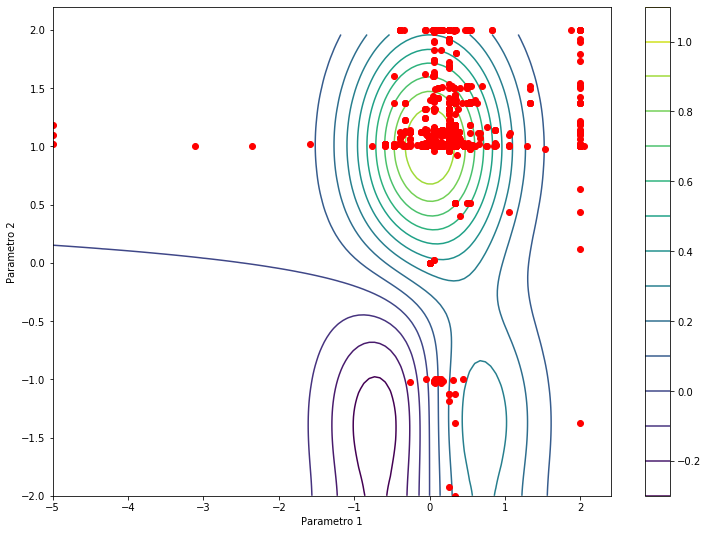

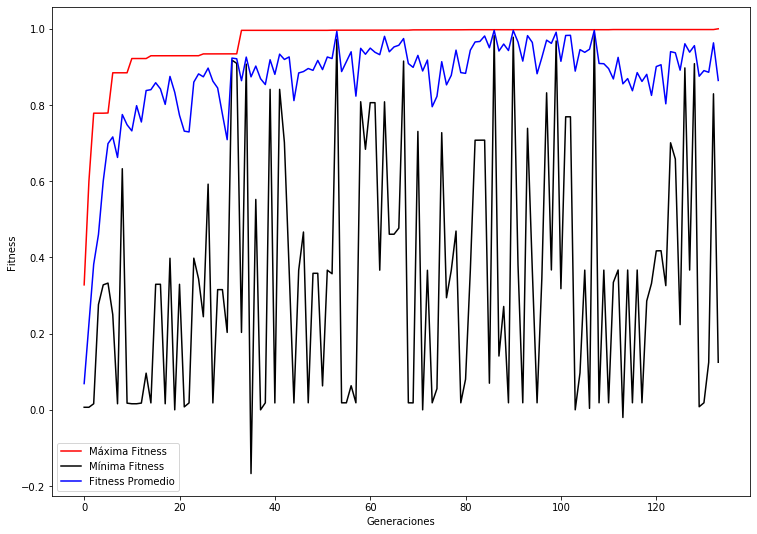

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12.5,9))

#plt.plot(x,np.squeeze(z),'k',linewidth=2);
#plt.title('Fitness Function')
#plt.xlabel('x');
#plt.ylabel('f(x)');
z.shape
plt.contour( xx, yy, z,[-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1] )
for pop_member in range(POP_SIZE):
    xdot=np.squeeze(trait[0,pop_member,:]);
    ydot=np.squeeze(trait[1,pop_member,:]);
    plt.plot(xdot,ydot,'ro');
plt.colorbar()
plt.xlabel('Parametro 1')
plt.ylabel('Parametro 2')

fig = plt.figure(figsize=(12.5,9))

plt.plot(t,bestfitness,'r',t,worstfitness,'k',t,avefitness,'b')
plt.legend(['Máxima Fitness','Mínima Fitness','Fitness Promedio'])
plt.xlabel('Generaciones')
plt.ylabel('Fitness')

In [26]:
np.min(z)

-0.35356734774867626